In time series literature, common features created:
1. Date / time related features
1. Lag features
1. Rolling window feature
1. Domain specific features

In [1]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import xgboost as xgb

from plotly.subplots import make_subplots
from multiprocessing import Pool
from functools import partial
from scipy.stats import ttest_rel, pearsonr, spearmanr

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from sktime.transformations.series.detrend import STLTransformer

from utils.common import read_bm_data, plot_confusion_matrix
from utils.features import compute_z_past, create_lag, create_rsi, create_dst

import os
import ta
import datetime
import tqdm
import warnings
import pickle

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df_wti_1m = pickle.load(open('./large_files/cl-1m.pkl', 'rb'))
df_wti_1m = df_wti_1m[(df_wti_1m['datetime'].dt.hour >= 8) & (df_wti_1m['datetime'].dt.hour < 16)]

df_wti = read_bm_data('./data/backtestmarket/cl-15m.csv')

# df = df_wti.copy()
# df = df[(df['datetime'].dt.hour >= 8) & (df['datetime'].dt.hour < 16)]
# df = df[(df['datetime'].dt.weekday == 2) & (df['datetime'].dt.year >= 2010) & (df['datetime'].dt.year <= 2019)]
# df.head()

In [3]:
df = df_wti_1m.copy()
df = df[(df['datetime'].dt.hour >= 8) & (df['datetime'].dt.hour < 16)]
df = df[(df['datetime'].dt.weekday == 2) & (df['datetime'].dt.year >= 2010) & (df['datetime'].dt.year <= 2019)]
df['month'] = df['datetime'].dt.month
df.head()

date  time   open   high    low  close  volume  \
834818  2010-01-06  0800  81.54  81.55  81.51  81.54     393   
834819  2010-01-06  0801  81.54  81.54  81.52  81.53     156   
834820  2010-01-06  0802  81.53  81.53  81.52  81.53      47   
834821  2010-01-06  0803  81.52  81.52  81.50  81.51      32   
834822  2010-01-06  0804  81.51  81.54  81.51  81.53      27   

                        datetime        day  month  
834818 2010-01-06 08:00:00-05:00  Wednesday      1  
834819 2010-01-06 08:01:00-05:00  Wednesday      1  
834820 2010-01-06 08:02:00-05:00  Wednesday      1  
834821 2010-01-06 08:03:00-05:00  Wednesday      1  
834822 2010-01-06 08:04:00-05:00  Wednesday      1

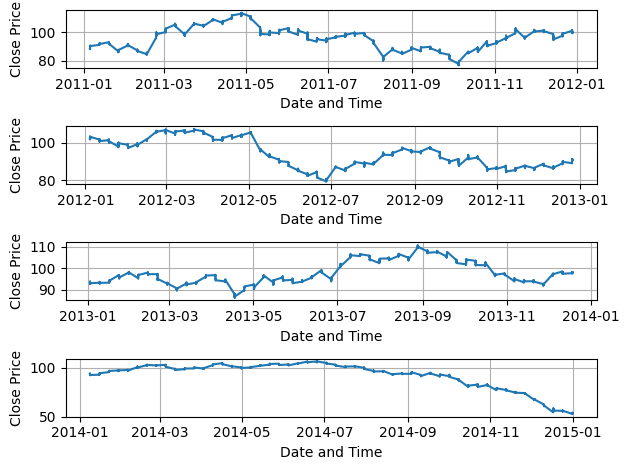

In [4]:
years = [2011, 2012, 2013, 2014]
fig, axs = plt.subplots(4, 1)

for year, ax in zip(years, axs):
    df_filter = df[df['datetime'].dt.year == year]
    ax.plot(df_filter['datetime'], df_filter['close'], linestyle='-')
    ax.set_xlabel('Date and Time')
    ax.set_ylabel('Close Price')
    # ax.set_ticks(rotation=45)
    ax.grid(True)
plt.tight_layout()
plt.show()

# Price
z: standard deviation relative to mean of past 1hr, 30m, 15m  
pct: percentage change relative to mean of past 1hr, 30m, 15m  
mean: mean of past 1hr, 30m, 15m  
std: standard deviation of past 1hr, 30m, 15m  

Can be used as feature or target

In [5]:
if os.path.isfile('./large_files/features.pkl'):
    df = pickle.load(open('./large_files/features.pkl', 'rb'))
else:
    df = compute_z_past(df, df_wti_1m, 1, 0, '1hr')
    df = compute_z_past(df, df_wti_1m, 0, 30, '30m')
    df = compute_z_past(df, df_wti_1m, 0, 15, '15m')
    pickle.dump(df, open('./large_files/features.pkl', 'wb'))
df.head(3)

date  time   open   high    low  close  volume  \
0  2010-01-06  0800  81.54  81.55  81.51  81.54     393   
1  2010-01-06  0801  81.54  81.54  81.52  81.53     156   
2  2010-01-06  0802  81.53  81.53  81.52  81.53      47   

                   datetime        day     z_1hr  ...     z_30m  pct_30m  \
0 2010-01-06 08:00:00-05:00  Wednesday  0.000000  ...  0.000000     0.00   
1 2010-01-06 08:01:00-05:00  Wednesday       NaN  ...       NaN    -0.01   
2 2010-01-06 08:02:00-05:00  Wednesday -0.707107  ... -0.707107    -0.01   

   mean_30m   std_30m  trend_30m     z_15m  pct_15m  mean_15m   std_15m  \
0    81.540  0.000000    neutral  0.000000     0.00    81.540  0.000000   
1    81.540       NaN    neutral       NaN    -0.01    81.540       NaN   
2    81.535  0.007071       down -0.707107    -0.01    81.535  0.007071   

   trend_15m  
0    neutral  
1    neutral  
2       down  

[3 rows x 24 columns]

Lag features

In [6]:
df = create_lag(df, 'z_15m', 1, 0)
df = create_lag(df, 'z_15m', 0, 30)
df = create_lag(df, 'z_15m', 0, 15)

df = create_lag(df, 'z_30m', 1, 0)
df = create_lag(df, 'z_30m', 0, 30)
df = create_lag(df, 'z_30m', 0, 15)

df.head(3)

date  time   open   high    low  close  volume  \
0  2010-01-06  0800  81.54  81.55  81.51  81.54     393   
1  2010-01-06  0801  81.54  81.54  81.52  81.53     156   
2  2010-01-06  0802  81.53  81.53  81.52  81.53      47   

                   datetime        day     z_1hr  ...  pct_15m  mean_15m  \
0 2010-01-06 08:00:00-05:00  Wednesday  0.000000  ...     0.00    81.540   
1 2010-01-06 08:01:00-05:00  Wednesday       NaN  ...    -0.01    81.540   
2 2010-01-06 08:02:00-05:00  Wednesday -0.707107  ...    -0.01    81.535   

    std_15m trend_15m  lag1hr_z_15m  lag30m_z_15m  lag15m_z_15m  lag1hr_z_30m  \
0  0.000000   neutral           0.0           0.0           0.0           0.0   
1       NaN   neutral           0.0           0.0           0.0           0.0   
2  0.007071      down           0.0           0.0           0.0           0.0   

  lag30m_z_30m  lag15m_z_30m  
0          0.0           0.0  
1          0.0           0.0  
2          0.0           0.0  

[3 rows x 30 columns]

Distance features

In [7]:
df = create_dst(df, [5, 15, 30, 60])

  0%|          | 0/3634 [00:00<?, ?it/s]

/home/quincy/Documents/takumi/utils/features.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day[f'dst_high_{period_minute}m'] = (feature_value - high) / high
/home/quincy/Documents/takumi/utils/features.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day[f'dst_low_{period_minute}m'] = (feature_value - low) / low
/home/quincy/Documents/takumi/utils/features.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Momentum indicators

In [8]:
df = create_rsi(df, [5, 10, 15, 30, 60])

  0%|          | 0/3634 [00:00<?, ?it/s]/home/quincy/Documents/takumi/utils/features.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day[f'rsi_{period}'] = ta.momentum.rsi(close=df_day['close'], window=period).copy()
/home/quincy/Documents/takumi/utils/features.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day[f'rsi_{period}'] = ta.momentum.rsi(close=df_day['close'], window=period).copy()
/home/quincy/Documents/takumi/utils/features.py:111: SettingWithCopyWarning: 
A value is trying to b

In [9]:
df.describe()

open           high            low          close  \
count  247408.000000  247408.000000  247408.000000  247408.000000   
mean       72.445582      72.478047      72.412957      72.445505   
std        21.880491      21.883396      21.877451      21.880395   
min        27.300000      27.360000      27.270000      27.300000   
25%        52.230000      52.260000      52.210000      52.230000   
50%        71.460000      71.490000      71.430000      71.460000   
75%        93.530000      93.560000      93.500000      93.530000   
max       113.370000     113.400000     113.210000     113.370000   

              volume          z_1hr        pct_1hr       mean_1hr  \
count  247408.000000  246785.000000  247408.000000  247408.000000   
mean      540.265662       0.006553       0.001331      72.445839   
std       792.797992       1.491729       0.347827      21.882380   
min         1.000000     -24.126902      -3.800000      27.543167   
25%       132.000000      -1.054187      -0.140000      52.263083   
50%       309.000000       0.017632       0.000000      71.471583   
75%       640.000000       1.075085       0.140000      93.511333   
max     25073.000000      17.337707       4.230000     112.923333   

             std_1hr          z_30m  ...   dst_high_60m    dst_low_60m  \
count  246785.000000  246784.000000  ...  216846.000000  216846.000000   
mean        0.126320       0.007084  ...      -0.003780       0.003883   
std         0.094145       1.508824  ...       0.004129       0.004377   
min         0.000000     -28.972627  ...      -0.049242       0.000000   
25%         0.061597      -1.045678  ...      -0.005009       0.001155   
50%         0.102055       0.013728  ...      -0.002505       0.002639   
75%         0.161451       1.065271  ...      -0.001062       0.005074   
max         0.945264      18.044795  ...       0.000000       0.061786   

        dst_mean_60m  dst_mean_high_60m  dst_mean_low_60m          rsi_5  \
count  216846.000000      216846.000000     216846.000000  245336.000000   
mean        0.000012          -0.003790          0.003872      50.111283   
std         0.003582           0.002890          0.002899      18.990351   
min        -0.037264          -0.039819          0.000124       0.000000   
25%        -0.001537          -0.004726          0.002007      36.420833   
50%         0.000028          -0.002975          0.003067      50.137726   
75%         0.001564          -0.001954          0.004815      63.859613   
max         0.041471          -0.000206          0.042585     100.000000   

              rsi_10         rsi_15         rsi_30         rsi_60  
count  242746.000000  240156.000000  232386.000000  216846.000000  
mean       50.095715      50.090754      50.075540      50.041517  
std        13.468427      11.132229       8.186322       6.226675  
min         0.000000       8.162723      13.867975      19.471577  
25%        41.006429      42.738038      44.751048      45.993257  
50%        50.156414      50.163663      50.133500      50.061490  
75%        59.274265      57.509888      55.420336      54.163135  
max        97.553977      95.232750      86.272034      82.503781  

[8 rows x 48 columns]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247408 entries, 0 to 247407
Data columns (total 55 columns):
 #   Column             Non-Null Count   Dtype                           
---  ------             --------------   -----                           
 0   date               247408 non-null  object                          
 1   time               247408 non-null  object                          
 2   open               247408 non-null  float64                         
 3   high               247408 non-null  float64                         
 4   low                247408 non-null  float64                         
 5   close              247408 non-null  float64                         
 6   volume             247408 non-null  int64                           
 7   datetime           247408 non-null  datetime64[ns, America/New_York]
 8   day                247408 non-null  object                          
 9   z_1hr              246785 non-null  float64                         
 

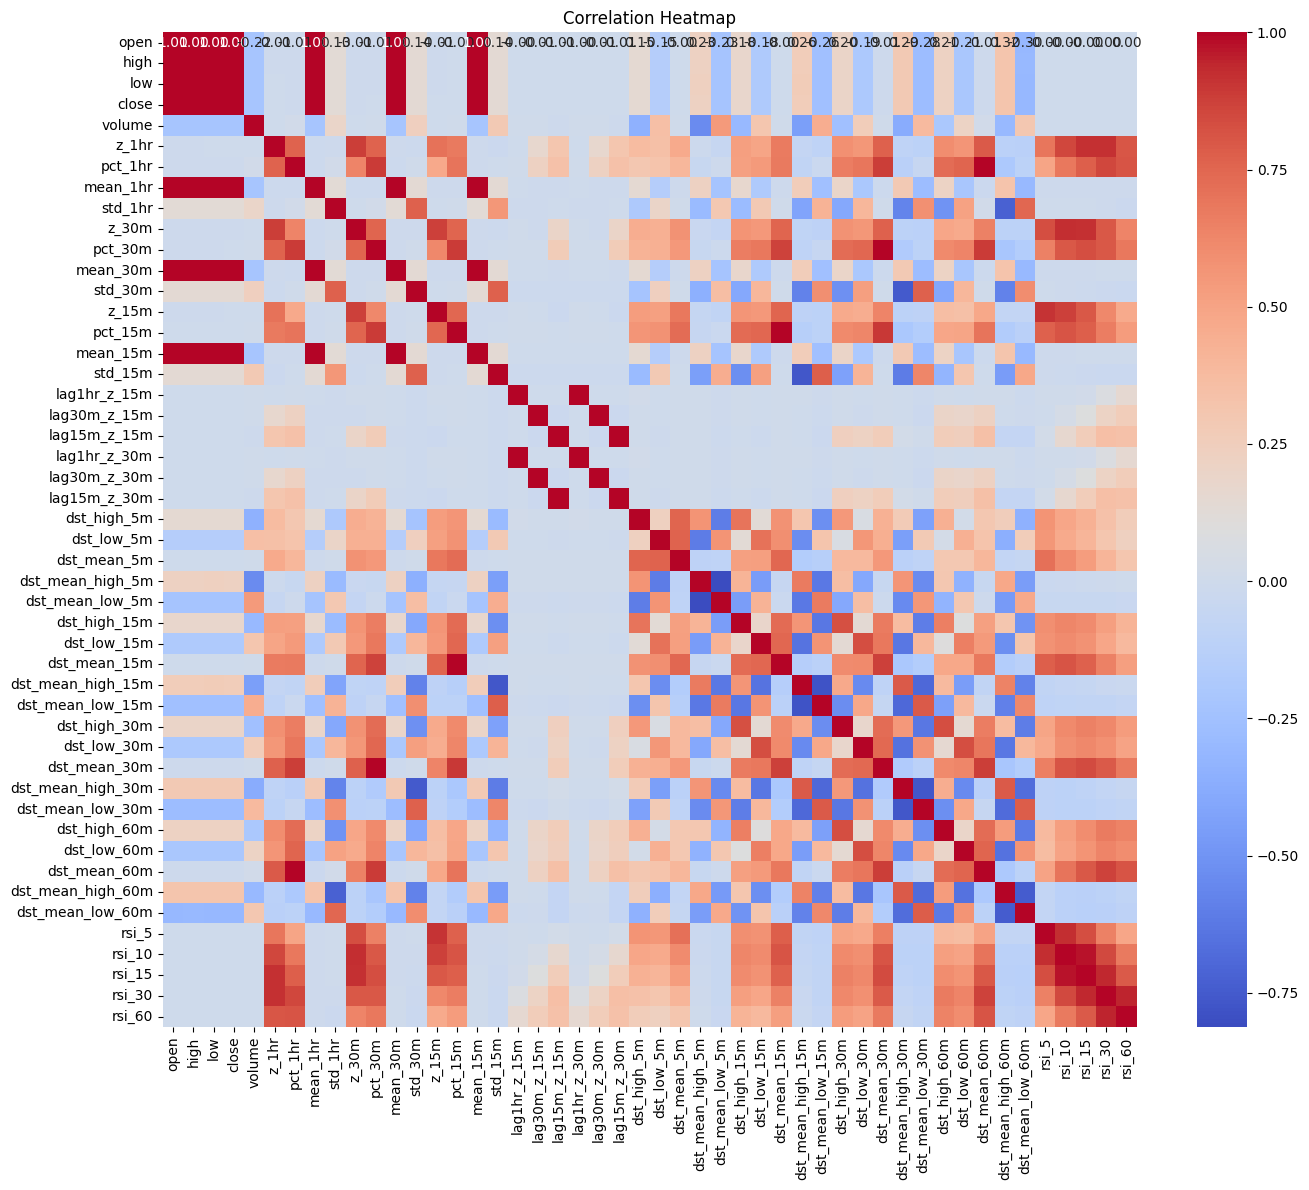

In [11]:
plt.figure(figsize=(14, 12))

sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.yticks(rotation=0)

plt.title('Correlation Heatmap')
plt.tight_layout()

plt.show()